In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":True, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False,
          "Load_data":True,
          "FLATTEN":False, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":True, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False,
          "Load_lepton_signal":True,
          "Load_pi0_signal":False}

Params, samples = Functions.create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run3 samples: 
['overlay']


In [3]:
samples_dict = {}

for sample in samples:
    if sample in Constants.Detector_variations:
        file = pd.read_pickle(loc_pkls+"DetVars/overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
        samples_dict[sample] = file
    if Params["Load_Signal_DetVars"] == True:
        file = pd.read_pickle(loc_pkls+"Signal_DetVars/"+Params["Run"]+f"_{sample}_"+Params["Reduced_state"]+".pkl")
        samples_dict[sample] = file
    else:
        if sample == 'signal':
            for HNL_mass in Constants.HNL_mass_samples:
                file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[HNL_mass] = file
        elif sample == 'pi0_signal':
            for HNL_mass in Constants.HNL_mass_pi0_samples:
                file = pd.read_pickle(loc_pkls+f"{sample}_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[str(HNL_mass)+"_pi0"] = file
        elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
            HNL_mass = sample
            file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
            samples_dict[HNL_mass] = file
        else: 
            file = pd.read_pickle(loc_pkls+f"{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_FINAL.pkl")
            samples_dict[sample] = file

print(samples_dict.keys())

dict_keys(['overlay'])


In [4]:
def Apply_swtrig(df):
    query="swtrig_pre>0"
    df.query(query)

def Apply_flash_shift(df, sample_type):
    #Only required for beam off, overlay, dirtoverlay and signal (i.e all except beamon data)
    if(sample_type=="beamoff"): df["flash_time"]=df["flash_time"] -0.359
    else: df["flash_time"]=df["flash_time"] - 0.304
    
Pre_swtrig_dict = {}
swtrig = {}
apply_swtrig = True

for sample in samples_dict:
    Pre_swtrig_dict[sample] = len(samples_dict[sample]) #Should weight this properly, i.e take sum of weights for the total number.
    if(apply_swtrig):
        swtrig[sample] = samples_dict[sample].query("swtrig_pre>0")
    if sample != "beamgood":
        Apply_flash_shift(samples_dict[sample], sample)
        
cut_dict = Constants.Preselection_dict_for_plot
        
samples_dict["overlay"]=samples_dict["overlay"].query(cut_dict['nslice'])
print("Made nslice cut")

Made nslice cut


## Calculate systematic error

In [5]:
#Calculate sys
variable = 'flash_time'

# Norm = sample_norms["overlay"]
if Params["Run"] == "run1":Norm = Constants.SF_overlay_run1
if Params["Run"] == "run3":Norm = Constants.SF_overlay_run3

xlims = [0,25]
nbins = 40
BINS = np.linspace(xlims[0],xlims[1], nbins)


In [6]:
results_dict_ppfx=Functions.All_reweight_err(samples_dict["overlay"],"weightsPPFX",variable,BINS,xlims,Norm)

print(f"Calculated ppfx uncertainty")

Calculated ppfx uncertainty


In [7]:
results_dict_genie=Functions.All_reweight_err(samples_dict["overlay"],"weightsGenie",variable,BINS,xlims,Norm)

print(f"Calculated genie uncertainty")

Calculated genie uncertainty


In [8]:
cov_ppfx = results_dict_ppfx["weightsPPFX"][0]
cov_genie = results_dict_genie["weightsGenie"][0]
var_Overlay = samples_dict["overlay"][variable]
# print(cov_PPFX)
overlaybkg=np.histogram(var_Overlay,bins=BINS,range=xlims)[0]

weight_Overlay=samples_dict["overlay"]["weight"]*Norm
#weighted hists
overlaybkg_weighted=np.histogram(var_Overlay,bins=BINS,range=xlims,weights=weight_Overlay)[0]

mc_w=np.histogram(var_Overlay,bins=BINS,range=xlims,weights=weight_Overlay**2)

mc_err=np.sqrt(mc_w[0])

# stat_bkgerr=np.sqrt(offbkg_stat**2+overlaybkg_stat**2+dirtbkg_stat**2) #Adding stat errors in quadrature, my way
stat_bkgerr=mc_err #Adding stat errors in quadrature

cov_mc_stat   = np.zeros([len(stat_bkgerr), len(stat_bkgerr)])
cov_mc_stat[np.diag_indices_from(cov_mc_stat)]=stat_bkgerr**2 #Don't actually need here

tot_ppfx_err=np.sqrt(np.diag(cov_ppfx))
tot_genie_err=np.sqrt(np.diag(cov_genie))
tot_mcerr = np.sqrt(np.diag(cov_ppfx+cov_genie))

print(tot_mcerr)
print(stat_bkgerr)

[ 30.77183112  14.1596379   13.60903112   9.51035634   8.78555178
   8.98045232   9.16499423   9.46117214   5.93993304 827.78172297
 856.40426836 870.79776988 850.7338938  861.51696199 860.76086068
 858.79827799 870.56147301 872.4708457  853.74680753 862.10731962
 898.86774842 884.37553466 860.50888159 871.79770485  26.69716023
   7.14859056   7.97841916   7.09244458   9.34325219   9.33634685
  12.83310114  11.93670575  12.78765724  16.44143514  16.74917244
  14.6611604    7.13497716   0.           0.        ]
[ 7.621753   4.9360666  5.180112   4.1072373  3.7784696  4.494261
  5.093512   4.013489   3.1973271 40.79592   42.42383   43.557583
 40.64203   42.07786   41.954857  43.67147   42.813354  43.375698
 43.10467   41.9184    43.29175   43.00236   42.47644   42.80342
  6.6406064  4.0063424  4.3100085  3.3514805  3.810963   4.0807285
  5.784712   5.3040376  4.6749835  6.497746   6.0121946  5.5788035
  3.888585   0.         0.       ]


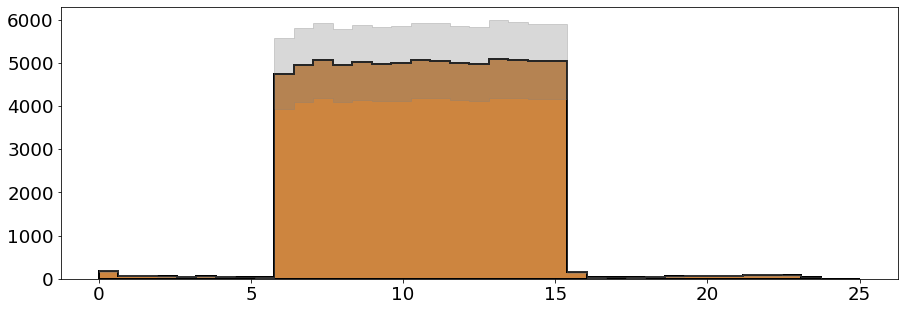

In [9]:
varis=[var_Overlay]
weights=[weight_Overlay]
colors=['peru']
labels=[fr"In-Cryo $\nu$"]

x,y=np.histogram(var_Overlay,bins=BINS,range=xlims,density=False)
x1,y=np.histogram(var_Overlay,bins=BINS,range=xlims)

plot=plt.hist(varis,
          label=labels,
          range=xlims,bins=BINS,
          histtype="stepfilled",
          stacked=True,density=False,linewidth=2,edgecolor="black",
          weights=weights, color=colors)

upvals=np.append((plot[0]+tot_mcerr),(plot[0]+tot_mcerr)[-1])
lowvals=np.append((plot[0]-tot_mcerr),(plot[0]-tot_mcerr)[-1])

plt.fill_between(y, lowvals, upvals,step="post",color="grey",alpha=0.3,zorder=2)

## Check fraction is flat across distribution

/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[0.17038676 0.1878176  0.18301334 0.15996846 0.17142152 0.16830891
 0.18143504 0.22366844 0.17004122 0.17433747 0.17306773 0.17236447
 0.17219574 0.17201983 0.17334425 0.17233807 0.17204374 0.17286652
 0.17072055 0.17345188 0.1765416  0.17446786 0.17098397 0.17314885
 0.17708641 0.20900402 0.20107061 0.19839006 0.1760024  0.16554265
 0.1861345  0.17797302 0.18824843 0.17927453 0.19830673 0.17996054
 0.17346193        nan        nan]


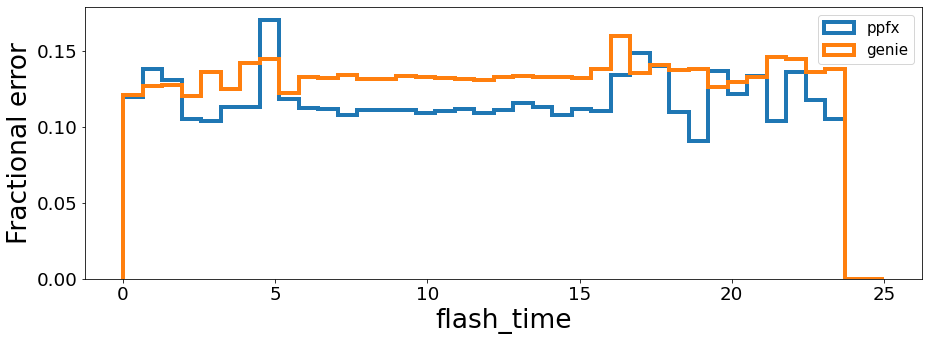

In [10]:
frac = np.divide(tot_mcerr, plot[0])
frac_ppfx = np.divide(tot_ppfx_err, plot[0])
frac_genie = np.divide(tot_genie_err, plot[0])
print(frac)

bins_cent=(BINS[:-1]+BINS[1:])/2
plt.hist(bins_cent,weights=np.nan_to_num(frac_ppfx),bins=BINS,range=xlims,density=False, label="ppfx", histtype="step", lw=4)
plt.hist(bins_cent,weights=np.nan_to_num(frac_genie),bins=BINS,range=xlims,density=False, label="genie",  histtype="step", lw=4)
plt.legend()

plt.xlabel(variable)
plt.ylabel(f"Fractional error")
plt.savefig("plots/Data_MC_comparison/Overlay_sys_unc/" + Params["Run"] + f"_{variable}_ppfx_and_genie_frac_err.png")

In [11]:
#Calculate average
length = len(frac)
total = sum(np.nan_to_num(frac))
total_ppfx = sum(np.nan_to_num(frac_ppfx))
total_genie = sum(np.nan_to_num(frac_genie))

mean = total/length
mean_ppfx = total_ppfx/length 
mean_genie = total_genie/length 

print(Params["Run"])

print(f"mean ppfx is {mean_ppfx}")
print(f"mean genie is {mean_genie}")

run3
mean ppfx is 0.1120298176212023
mean genie is 0.12710881709997293
